In [1]:
%pylab inline
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# load monkey FI excitatory neurons data...

In [2]:
insData = sc.read('../data_h5/Ext_230821.h5ad')
insData

AnnData object with n_obs × n_vars = 21733 × 19944
    obs: 'batch', 'doublet_score', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cluster_labels', 'sampleLayers'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cluster_labels_colors', 'cluster_names', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sampleLayers_colors', 'tsne', 'umap'
    obsm: 'X_harmonypca', 'X_pca', 'X_tsne', 'X_umap', 'X_umapharmony', 'X_umapraw'
    varm: 'PCs'
    layers: 'RawCounts'
    obsp: 'connectivities', 'distances'

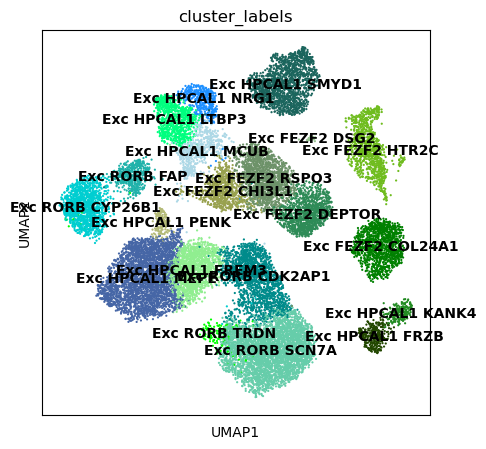

In [3]:
figsize(5,5)
sc.pl.umap(insData,color=['cluster_labels'], legend_loc='on data', size=10)

In [4]:
ins_adata=sc.AnnData(insData.layers['RawCounts'].X,dict(obs_names=insData.obs_names),dict(var_names=insData.var_names))
ins_adata.obs['batch'] = insData.obs['batch']
ins_adata.obs['brainArea'] = 'Ins'
ins_adata.obs['species'] = 'monkey'
ins_adata.obs['cellTypeID'] = insData.obs['leiden']
ins_adata.obs['cellType_labels'] = insData.obs['cluster_labels']

In [5]:
# load the human counts data...
MTG_adata0 = sc.read('./HodgeData/Hodge_MTG.h5ad')

In [6]:
MTG_adata = sc.AnnData(MTG_adata0.layers['rawCounts'],dict(obs_names=MTG_adata0.obs_names),dict(var_names=MTG_adata0.var_names))
MTG_adata.obs['class'] = MTG_adata0.obs['class']
MTG_adata.obs['subclass'] = MTG_adata0.obs['subclass']
MTG_adata.obs['cluster'] = MTG_adata0.obs['cluster']
MTG_adata.obs['total_counts_mt'] = MTG_adata0.obs['total_counts_mt']
MTG_adata.obs['pct_counts_mt'] = MTG_adata0.obs['pct_counts_mt']

MTG_adata.obs['species'] = 'human'
MTG_adata.obs['brainArea'] = 'MTG'

In [7]:
MTG_adata

AnnData object with n_obs × n_vars = 15603 × 50281
    obs: 'class', 'subclass', 'cluster', 'total_counts_mt', 'pct_counts_mt', 'species', 'brainArea'

In [8]:
ins_adata

AnnData object with n_obs × n_vars = 21733 × 19944
    obs: 'batch', 'brainArea', 'species', 'cellTypeID', 'cellType_labels'

In [9]:
MTG_adata.obs['class']

F1S4_160106_001_B01        GABAergic
F1S4_160106_001_C01    Glutamatergic
F1S4_160106_001_E01    Glutamatergic
F1S4_160106_001_G01    Glutamatergic
F1S4_160106_001_H01    Glutamatergic
                           ...      
F2S4_170405_060_B01    Glutamatergic
F2S4_170405_060_C01    Glutamatergic
F2S4_170405_060_E01    Glutamatergic
F2S4_170405_060_F01        GABAergic
F2S4_170405_060_H01        GABAergic
Name: class, Length: 15603, dtype: category
Categories (3, object): ['GABAergic', 'Glutamatergic', 'Non-neuronal']

In [10]:
# only select the excitatory neurons.
MTG_adata = MTG_adata[MTG_adata.obs['class']=='Glutamatergic']

In [11]:
adata = ins_adata.concatenate(MTG_adata,index_unique = None)
adata.var['mt'] = adata.var_names.isin(["ND1","ND2","COX1","COX2","COX3","ATP6","ATP8","ND3","ND4","ND5","ND6","ND4L","CYTB"])

In [12]:
adata.write('./data_tem/tem_Ext_integrated_ins_vs_MTG_step1.h5ad')

# integrate the datasets and compare the clusters...

In [13]:
# adata = sc.read('./data_tem/tem_Ext_integrated_ins_vs_MTG_step1.h5ad')

In [14]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(
    adata,
    batch_key="batch",
    flavor="seurat",
    n_top_genes=2500,
    subset=True,
    min_mean=0.015, 
    max_mean=10,
    min_disp=0.05
)

In [15]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 32258 × 2500
    obs: 'batch', 'brainArea', 'species', 'cellTypeID', 'cellType_labels', 'class', 'subclass', 'cluster', 'total_counts_mt', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'

In [16]:
sc.pp.regress_out(adata, ['total_counts'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

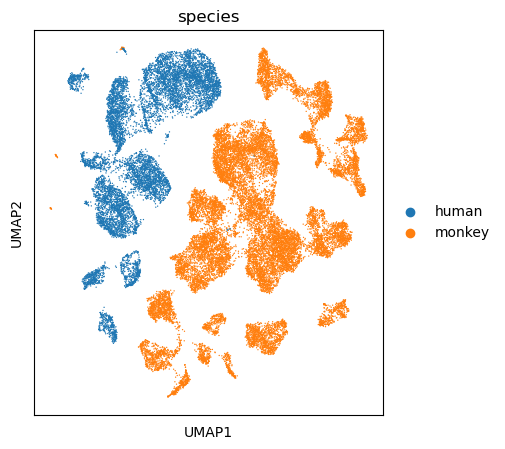

In [17]:
figsize(5,4.5)
sc.pl.umap(adata,color=['species'])

## Integrate with harmoney

In [18]:
import harmonypy as hm
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, ['batch','species'],theta=10,max_iter_harmony=10,max_iter_kmeans=20)

adata.obsm['X_harmonypca'] = ho.Z_corr.T
sc.pp.neighbors(adata, use_rep='X_harmonypca',n_neighbors=10, n_pcs=40)

adata.obsm['X_umapraw'] = adata.obsm['X_umap']
sc.tl.umap(adata)
adata.obsm['X_umapharmony'] = adata.obsm['X_umap']

2025-03-01 12:56:52,490 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-01 12:57:23,047 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-01 12:57:23,299 - harmonypy - INFO - Iteration 1 of 10
2025-03-01 12:57:48,779 - harmonypy - INFO - Iteration 2 of 10
2025-03-01 12:58:13,877 - harmonypy - INFO - Iteration 3 of 10
2025-03-01 12:58:34,652 - harmonypy - INFO - Iteration 4 of 10
2025-03-01 12:58:52,317 - harmonypy - INFO - Iteration 5 of 10
2025-03-01 12:59:12,373 - harmonypy - INFO - Iteration 6 of 10
2025-03-01 12:59:23,852 - harmonypy - INFO - Iteration 7 of 10
2025-03-01 12:59:33,460 - harmonypy - INFO - Iteration 8 of 10
2025-03-01 12:59:43,389 - harmonypy - INFO - Iteration 9 of 10
2025-03-01 13:00:00,427 - harmonypy - INFO - Iteration 10 of 10
2025-03-01 13:00:09,906 - harmonypy - INFO - Stopped before convergence


In [19]:
adata

AnnData object with n_obs × n_vars = 32258 × 2500
    obs: 'batch', 'brainArea', 'species', 'cellTypeID', 'cellType_labels', 'class', 'subclass', 'cluster', 'total_counts_mt', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'species_colors'
    obsm: 'X_pca', 'X_umap', 'X_harmonypca', 'X_umapraw', 'X_umapharmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

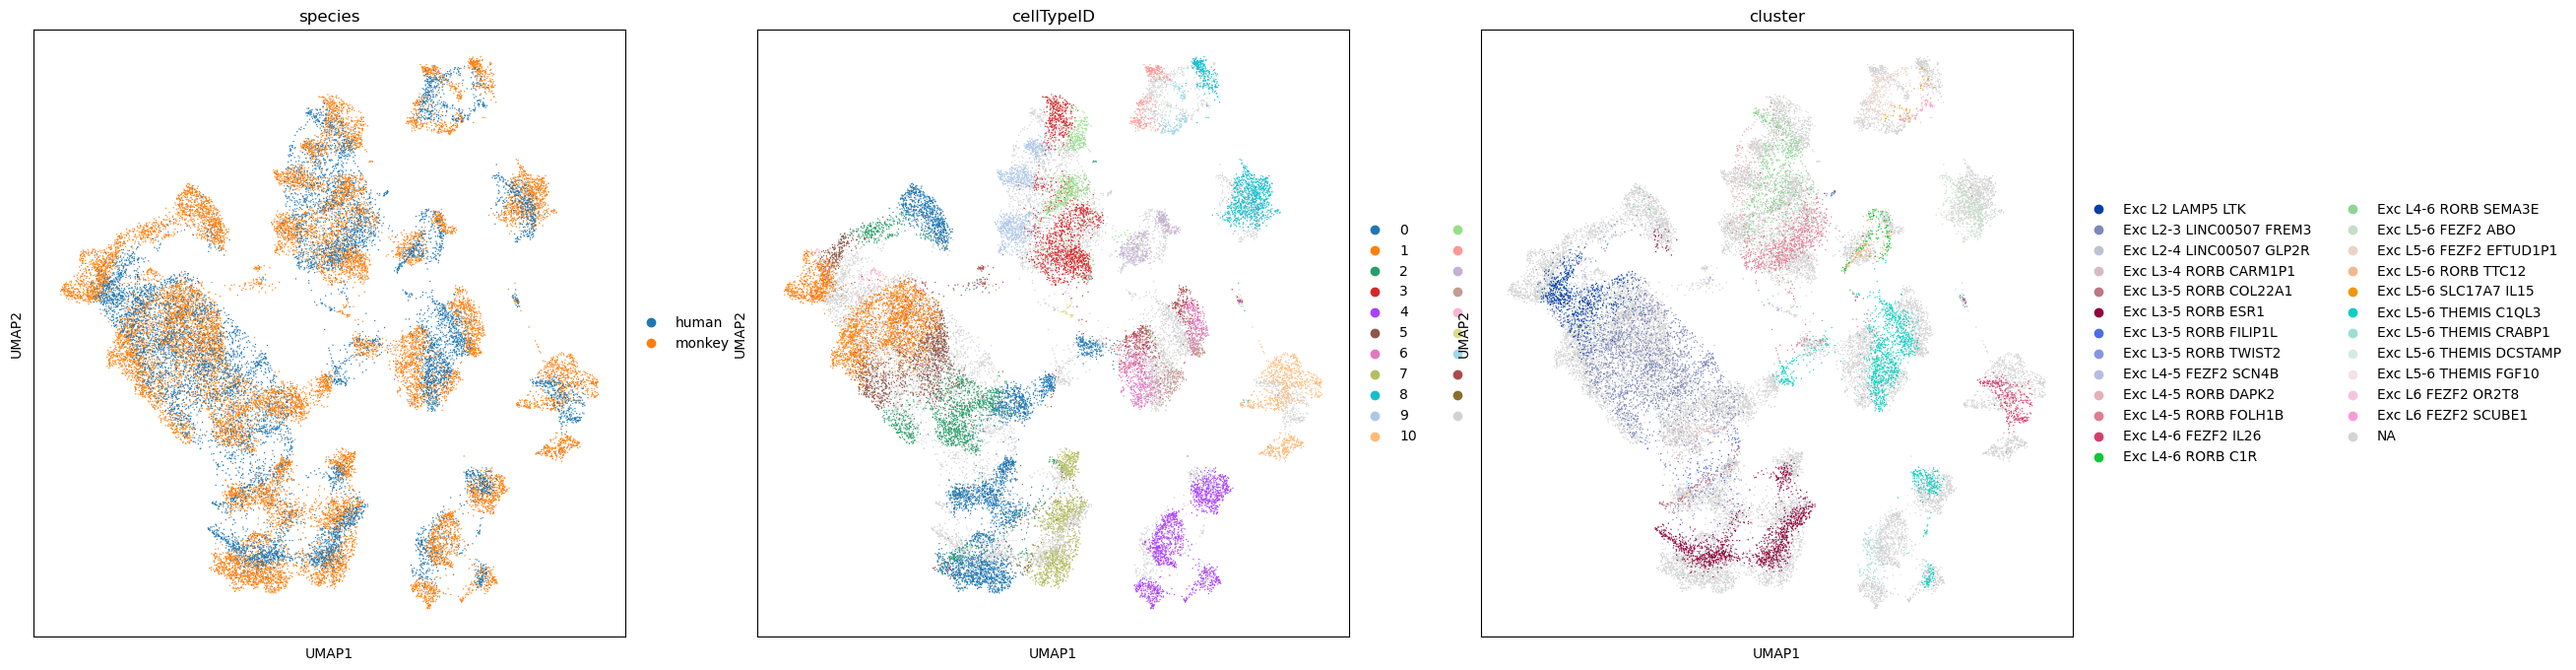

In [20]:
figsize(8,8)
sc.pl.umap(adata,color=['species','cellTypeID','cluster'])

In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%pylab inline
import sys
sys.path.append('../tools')
from two_species_heatmap import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [22]:
sc.pp.neighbors(adata,  metric='euclidean',use_rep = 'X_harmonypca' )
sc.tl.louvain(adata, resolution = 1.8, key_added = 'louvain')
adata.obs['louvain_1_8'] = adata.obs['louvain']

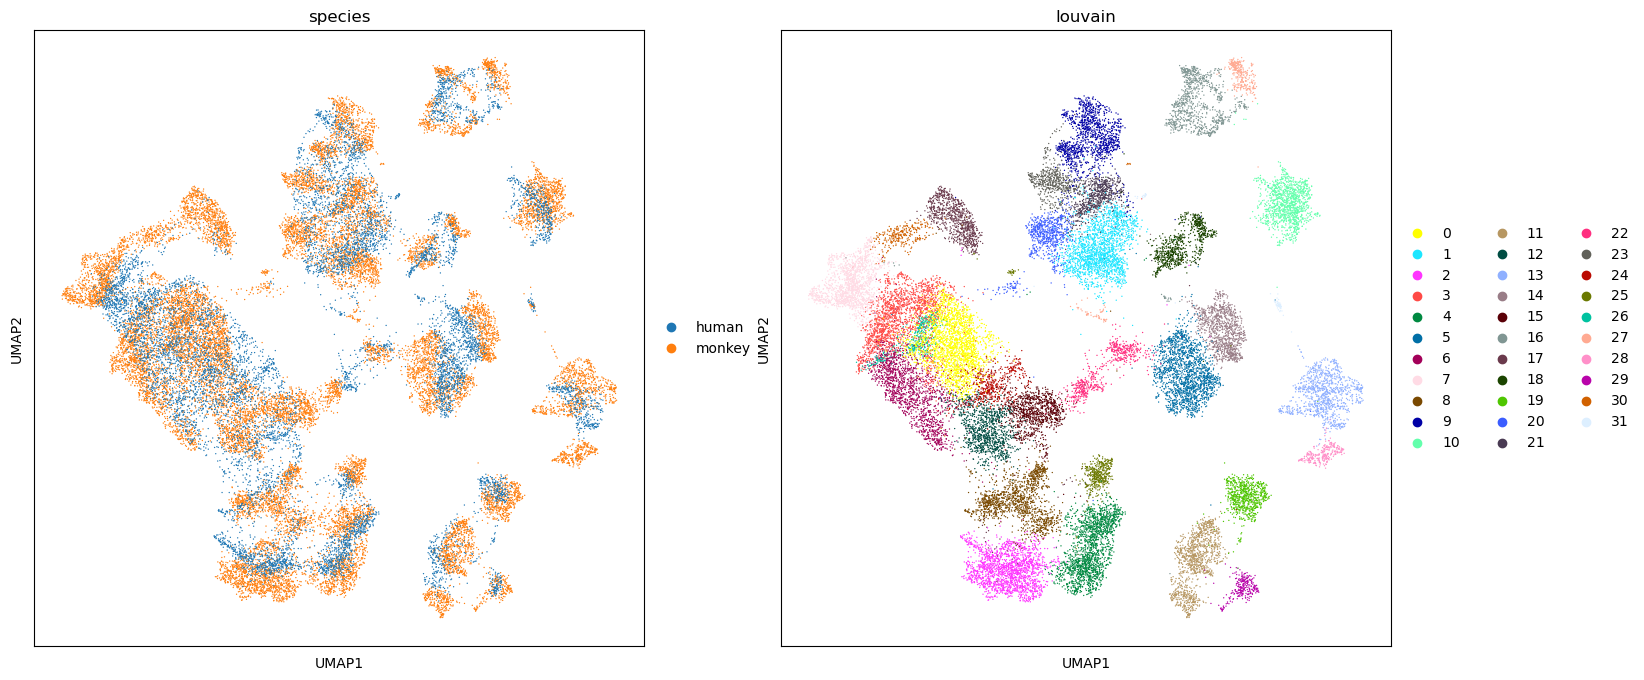

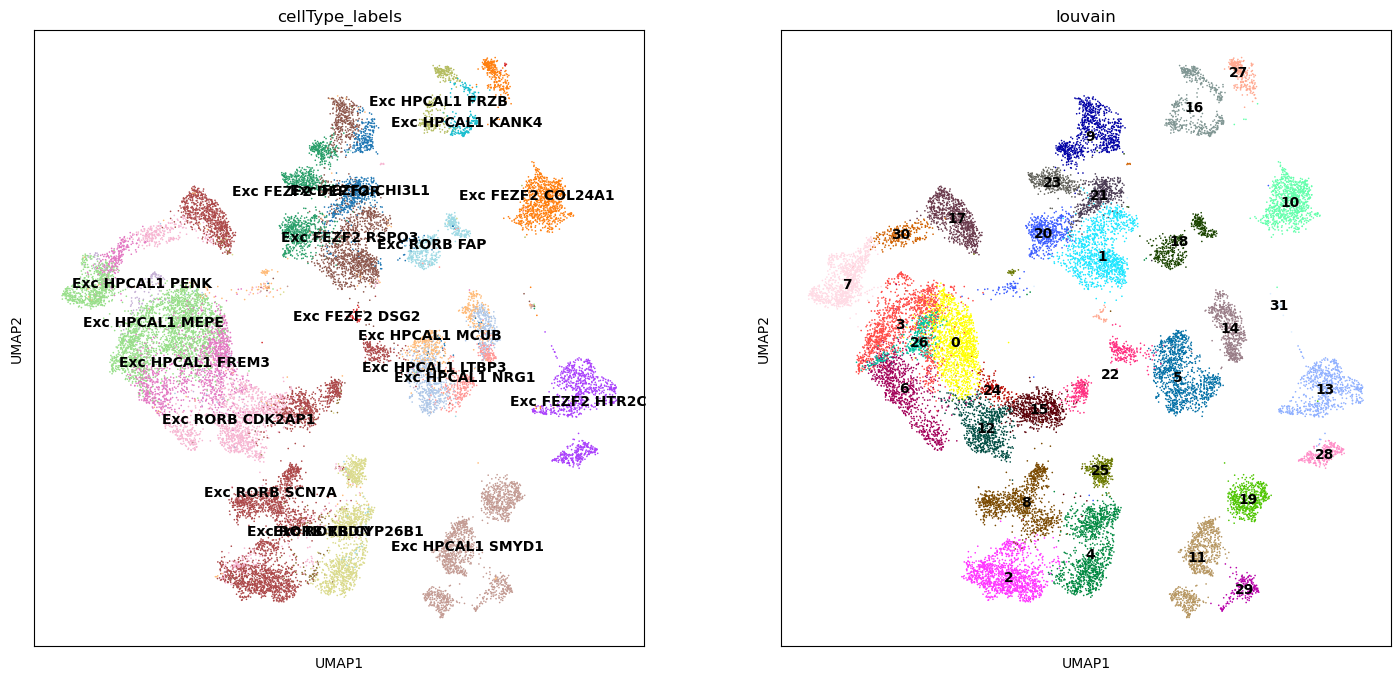

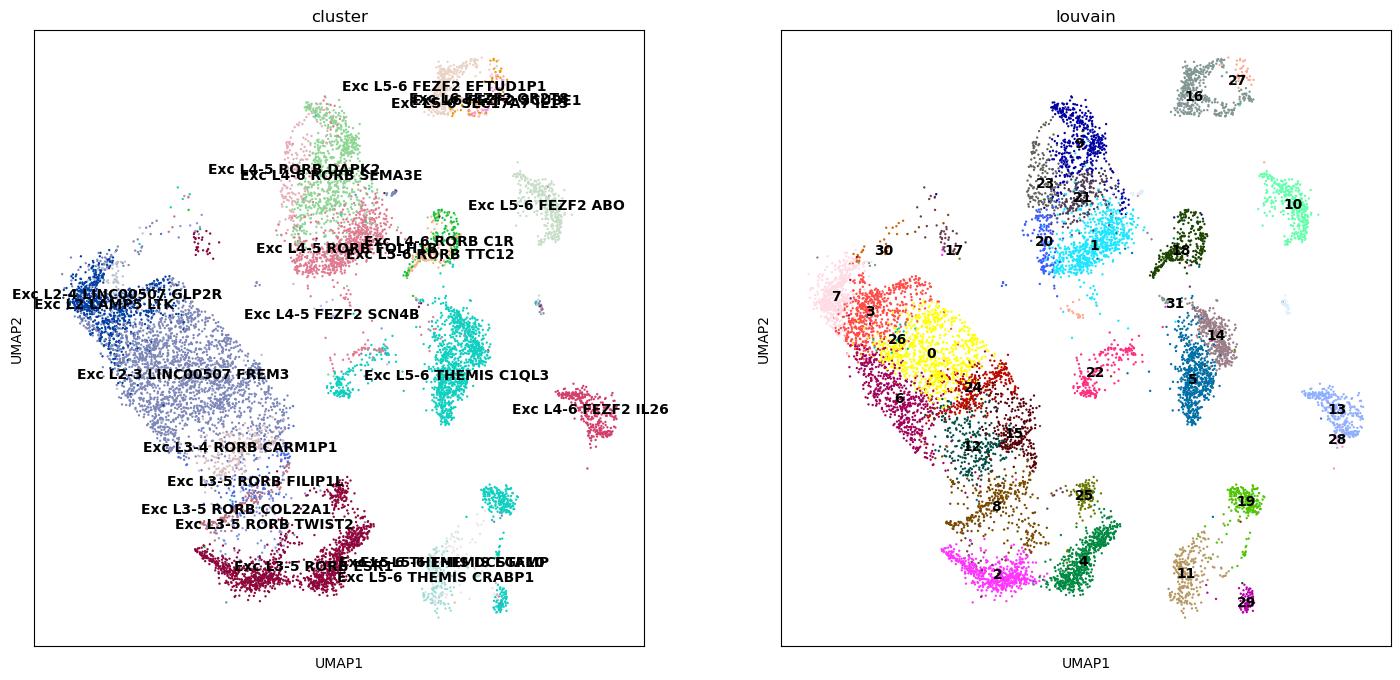

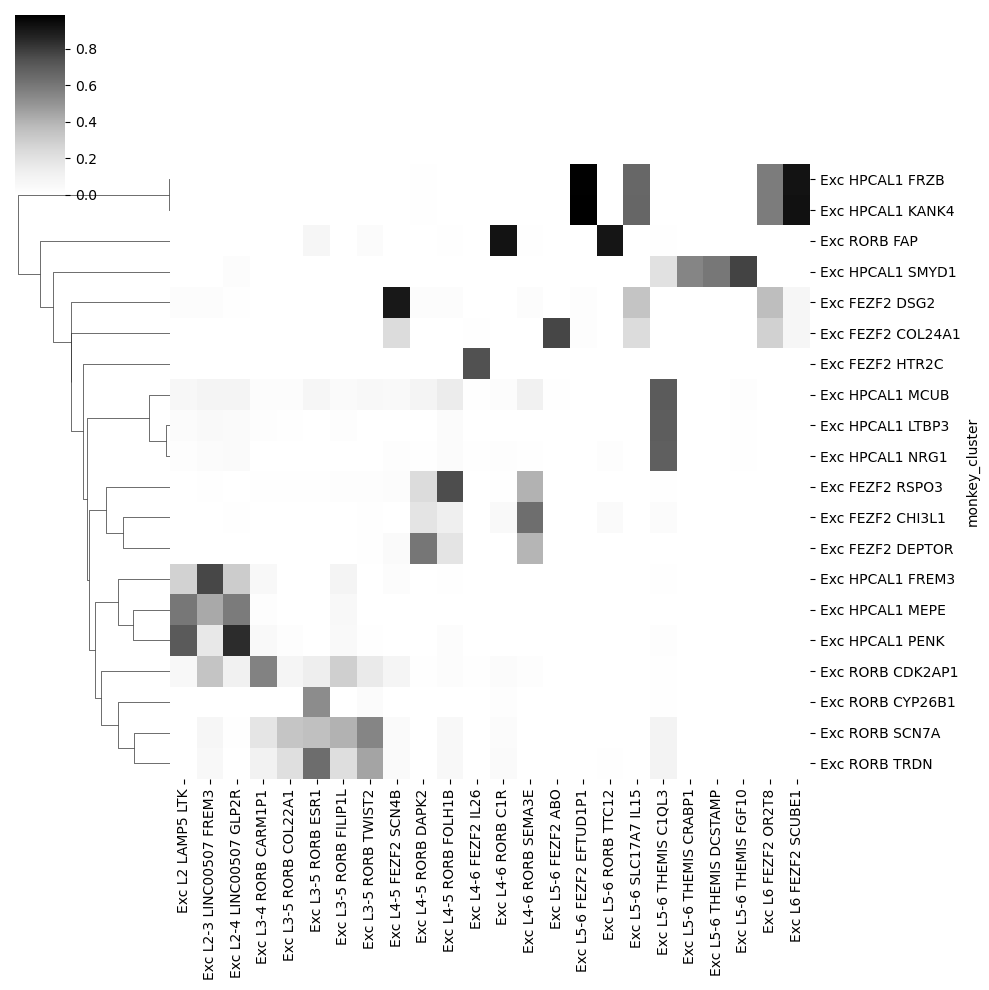

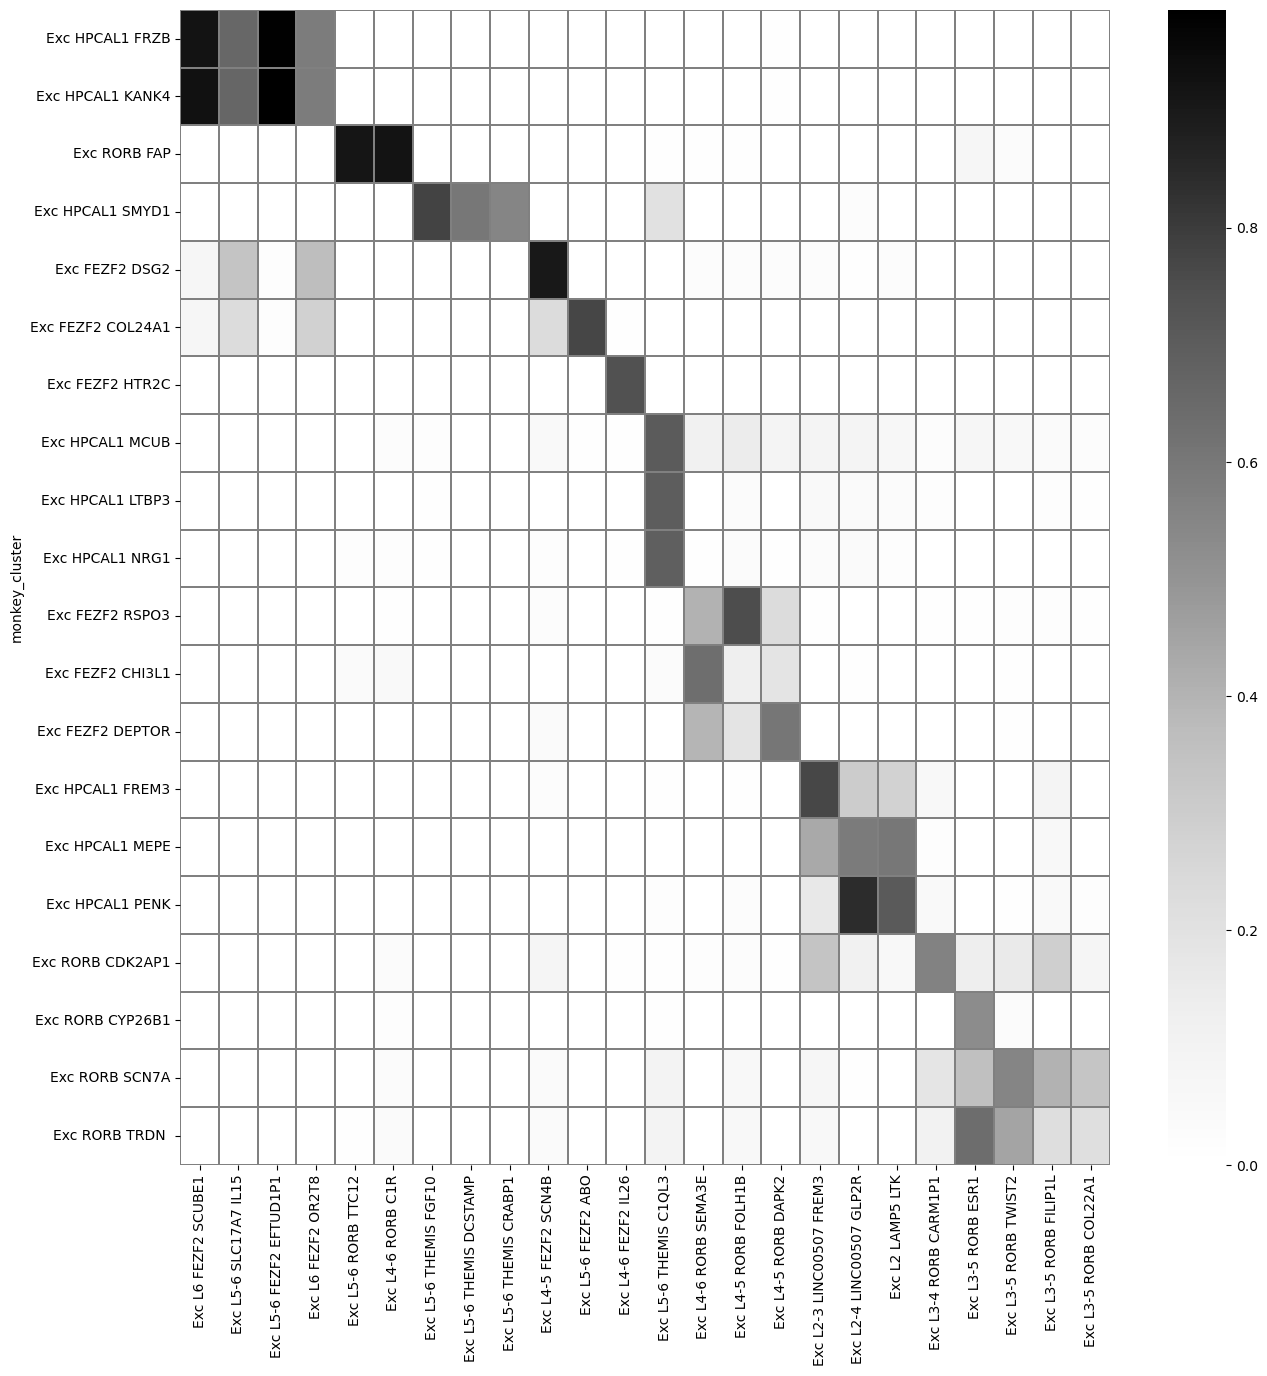

In [23]:
plot_GliaMatrix_ins_vs_v1_lovain_1_8 = two_species_heatmap(adata, species_1 = 'monkey', species_2 = 'human',\
                species_1_key = 'cellType_labels', species_2_key = 'cluster',\
                louvain = 1.8)#,figure_path = 'neurons_heatmap_cmp.png')

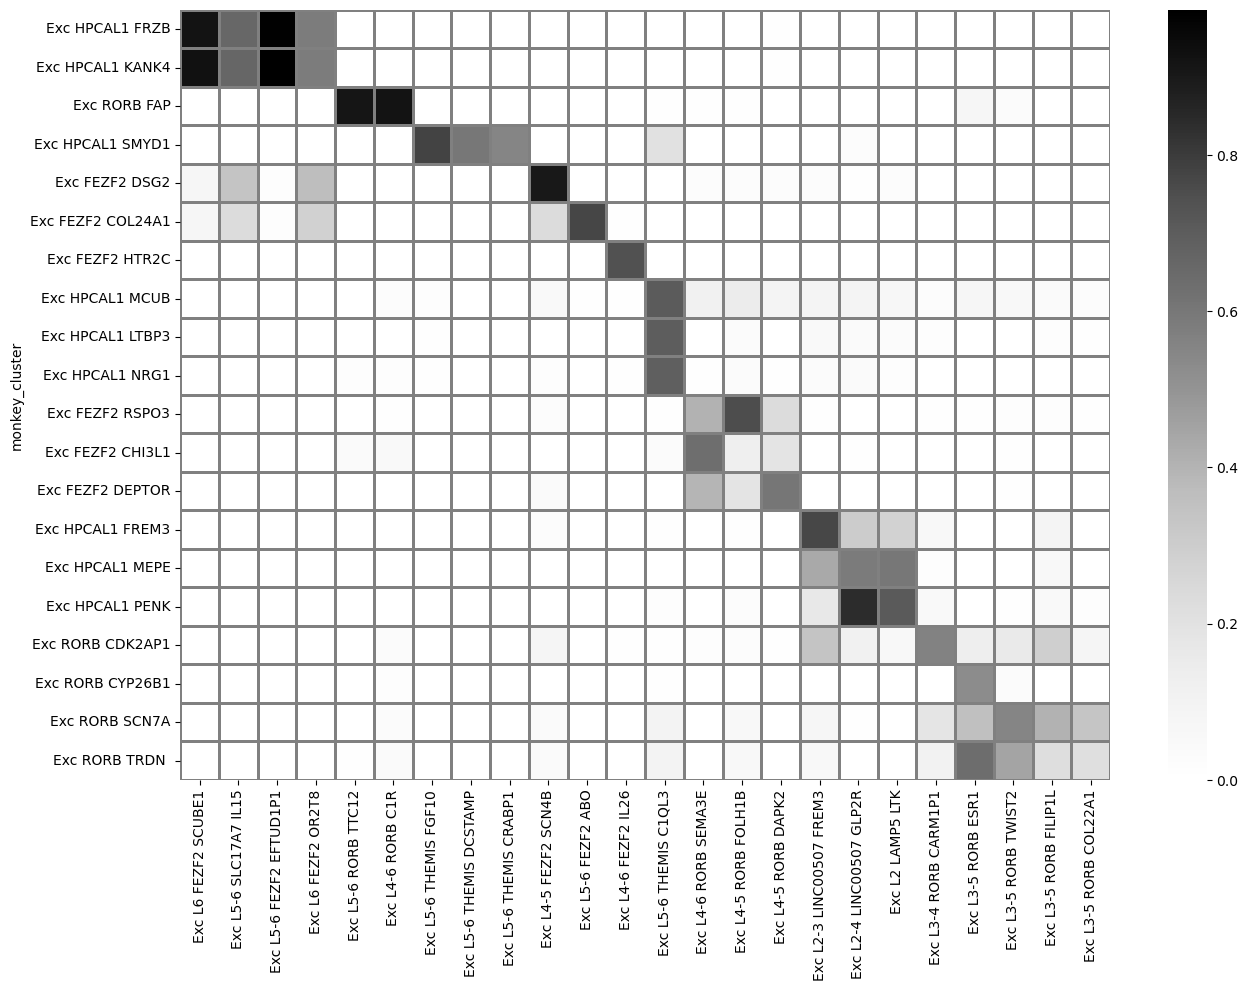

In [24]:
plt.figure(figsize = (15,10))
sns_plot = sns.heatmap(plot_GliaMatrix_ins_vs_v1_lovain_1_8, cmap='Greys', cbar=True, xticklabels=1,yticklabels=1, linewidth = 1, linecolor = 'gray')
# plt.savefig('figs/cmpMatrix_mk_vs_hu_500VirableGenes.pdf',dpi = 600, )

In [25]:
adata.uns['df_clusterCmpMatrix_louvain_1_8'] = plot_GliaMatrix_ins_vs_v1_lovain_1_8

In [26]:
adata.write('./data_tem/integrated_Exc_ins_vs_MTG_final.h5ad',compression='gzip')

In [27]:
adata

AnnData object with n_obs × n_vars = 32258 × 2500
    obs: 'batch', 'brainArea', 'species', 'cellTypeID', 'cellType_labels', 'class', 'subclass', 'cluster', 'total_counts_mt', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts', 'n_counts', 'louvain', 'louvain_1_8'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'species_colors', 'cellTypeID_colors', 'cluster_colors', 'louvain', 'louvain_colors', 'df_clusterCmpMatrix_louvain_1_8'
    obsm: 'X_pca', 'X_umap', 'X_harmonypca', 'X_umapraw', 'X_umapharmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

#### Plot figures...

In [28]:
adata = sc.read('./data_tem/integrated_Exc_ins_vs_MTG_final.h5ad')

In [29]:
plot_matrix_mk_vs_hu_lovain_1_8 = adata.uns['df_clusterCmpMatrix_louvain_1_8']

In [30]:
plot_GliaMatrix_ins_vs_v1_lovain_1_8.index

Index(['Exc HPCAL1 FRZB', 'Exc HPCAL1 KANK4', 'Exc RORB FAP',
       'Exc HPCAL1 SMYD1', 'Exc FEZF2 DSG2', 'Exc FEZF2 COL24A1',
       'Exc FEZF2 HTR2C', 'Exc HPCAL1 MCUB', 'Exc HPCAL1 LTBP3',
       'Exc HPCAL1 NRG1', 'Exc FEZF2 RSPO3', 'Exc FEZF2 CHI3L1',
       'Exc FEZF2 DEPTOR', 'Exc HPCAL1 FREM3', 'Exc HPCAL1 MEPE',
       'Exc HPCAL1 PENK', 'Exc RORB CDK2AP1', 'Exc RORB CYP26B1',
       'Exc RORB SCN7A', 'Exc RORB TRDN '],
      dtype='object', name='monkey_cluster')

In [31]:
plot_GliaMatrix_ins_vs_v1_lovain_1_8.columns

Index(['Exc L6 FEZF2 SCUBE1', 'Exc L5-6 SLC17A7 IL15',
       'Exc L5-6 FEZF2 EFTUD1P1', 'Exc L6 FEZF2 OR2T8', 'Exc L5-6 RORB TTC12',
       'Exc L4-6 RORB C1R', 'Exc L5-6 THEMIS FGF10', 'Exc L5-6 THEMIS DCSTAMP',
       'Exc L5-6 THEMIS CRABP1', 'Exc L4-5 FEZF2 SCN4B', 'Exc L5-6 FEZF2 ABO',
       'Exc L4-6 FEZF2 IL26', 'Exc L5-6 THEMIS C1QL3', 'Exc L4-6 RORB SEMA3E',
       'Exc L4-5 RORB FOLH1B', 'Exc L4-5 RORB DAPK2',
       'Exc L2-3 LINC00507 FREM3', 'Exc L2-4 LINC00507 GLP2R',
       'Exc L2 LAMP5 LTK', 'Exc L3-4 RORB CARM1P1', 'Exc L3-5 RORB ESR1',
       'Exc L3-5 RORB TWIST2', 'Exc L3-5 RORB FILIP1L',
       'Exc L3-5 RORB COL22A1'],
      dtype='object')

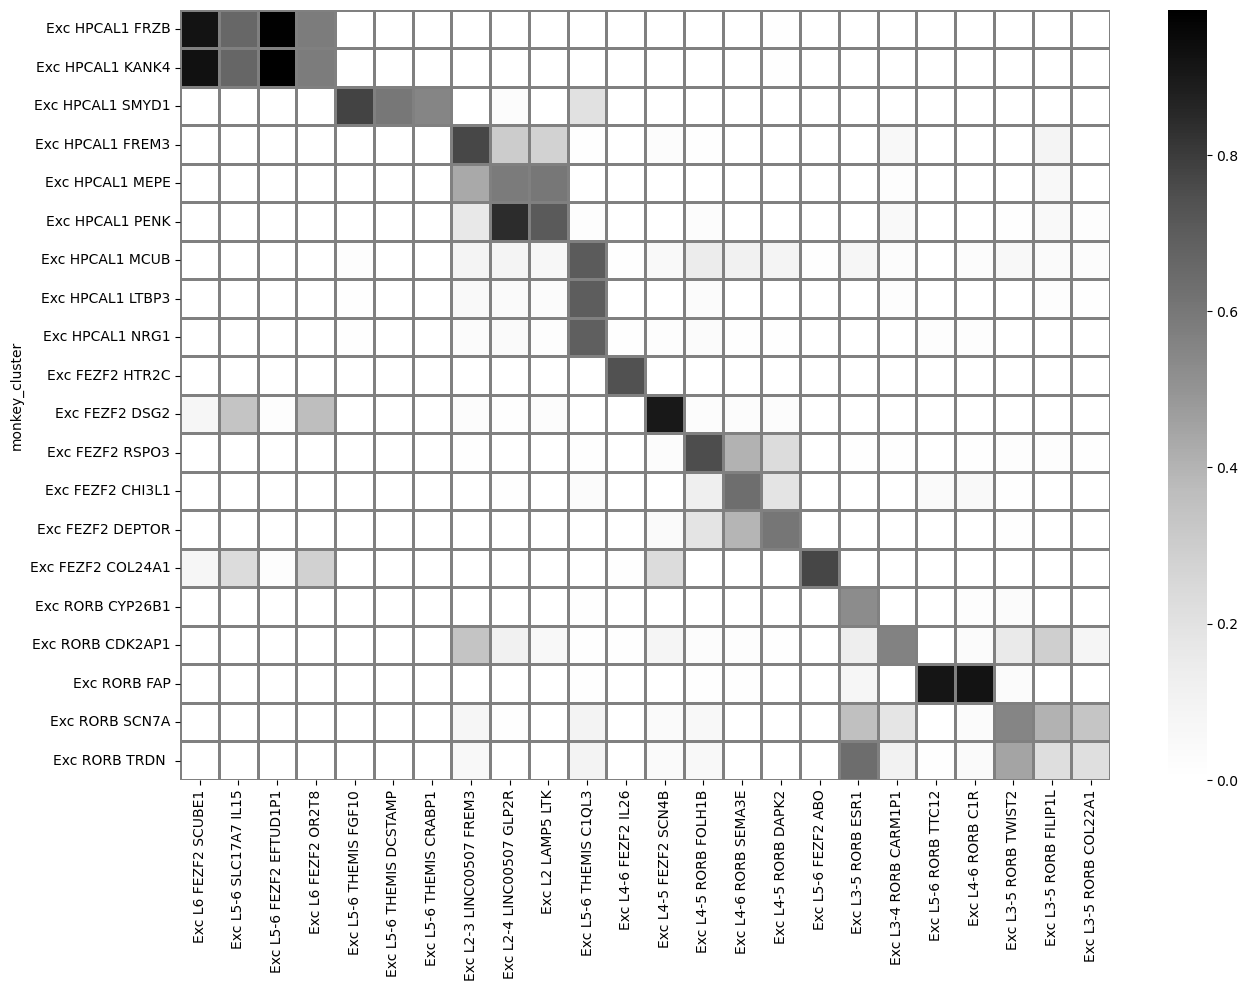

In [33]:
index_order = ['Exc HPCAL1 FRZB', 'Exc HPCAL1 KANK4',                                  # HPCAL1
               'Exc HPCAL1 SMYD1',                                                       # HPCAL1
               'Exc HPCAL1 FREM3', 'Exc HPCAL1 MEPE', 'Exc HPCAL1 PENK',                # HPCAL1
               'Exc HPCAL1 MCUB', 'Exc HPCAL1 LTBP3', 'Exc HPCAL1 NRG1',              # HPCAL1
               
               'Exc FEZF2 HTR2C',                                                         # FEZF2
               'Exc FEZF2 DSG2',                                                       # FEZF2
               'Exc FEZF2 RSPO3', 'Exc FEZF2 CHI3L1', 'Exc FEZF2 DEPTOR',               # FEZF2
               'Exc FEZF2 COL24A1',                                                    # FEZF2
               
               'Exc RORB CYP26B1',                                                        # RORB
               'Exc RORB CDK2AP1',                                                        # RORB
               'Exc RORB FAP',                                                            # RORB
               'Exc RORB SCN7A', 'Exc RORB TRDN ',]                                     # RORB
column_order = ['Exc L6 FEZF2 SCUBE1', 'Exc L5-6 SLC17A7 IL15', 'Exc L5-6 FEZF2 EFTUD1P1', 'Exc L6 FEZF2 OR2T8',
                'Exc L5-6 THEMIS FGF10', 'Exc L5-6 THEMIS DCSTAMP', 'Exc L5-6 THEMIS CRABP1', 
                'Exc L2-3 LINC00507 FREM3', 'Exc L2-4 LINC00507 GLP2R', 'Exc L2 LAMP5 LTK',
                'Exc L5-6 THEMIS C1QL3', 

                'Exc L4-6 FEZF2 IL26',
                'Exc L4-5 FEZF2 SCN4B',
                'Exc L4-5 RORB FOLH1B', 'Exc L4-6 RORB SEMA3E', 'Exc L4-5 RORB DAPK2',
                'Exc L5-6 FEZF2 ABO',
                
                'Exc L3-5 RORB ESR1', 
                'Exc L3-4 RORB CARM1P1',
                'Exc L5-6 RORB TTC12', 'Exc L4-6 RORB C1R', 
                'Exc L3-5 RORB TWIST2', 'Exc L3-5 RORB FILIP1L', 'Exc L3-5 RORB COL22A1',]
plot_matrix_mk_vs_hu_lovain_0_8 = plot_matrix_mk_vs_hu_lovain_1_8.reindex(index=index_order, columns=column_order)

plt.figure(figsize = (15,10))
sns_plot = sns.heatmap(plot_matrix_mk_vs_hu_lovain_0_8, cmap='Greys', cbar=True, xticklabels=1,yticklabels=1, linewidth = 1, linecolor = 'gray')
plt.savefig('figures/excCmpMatrix_mkIns_vs_hodgeMTG_2500VirableGenes.pdf',dpi = 600, )

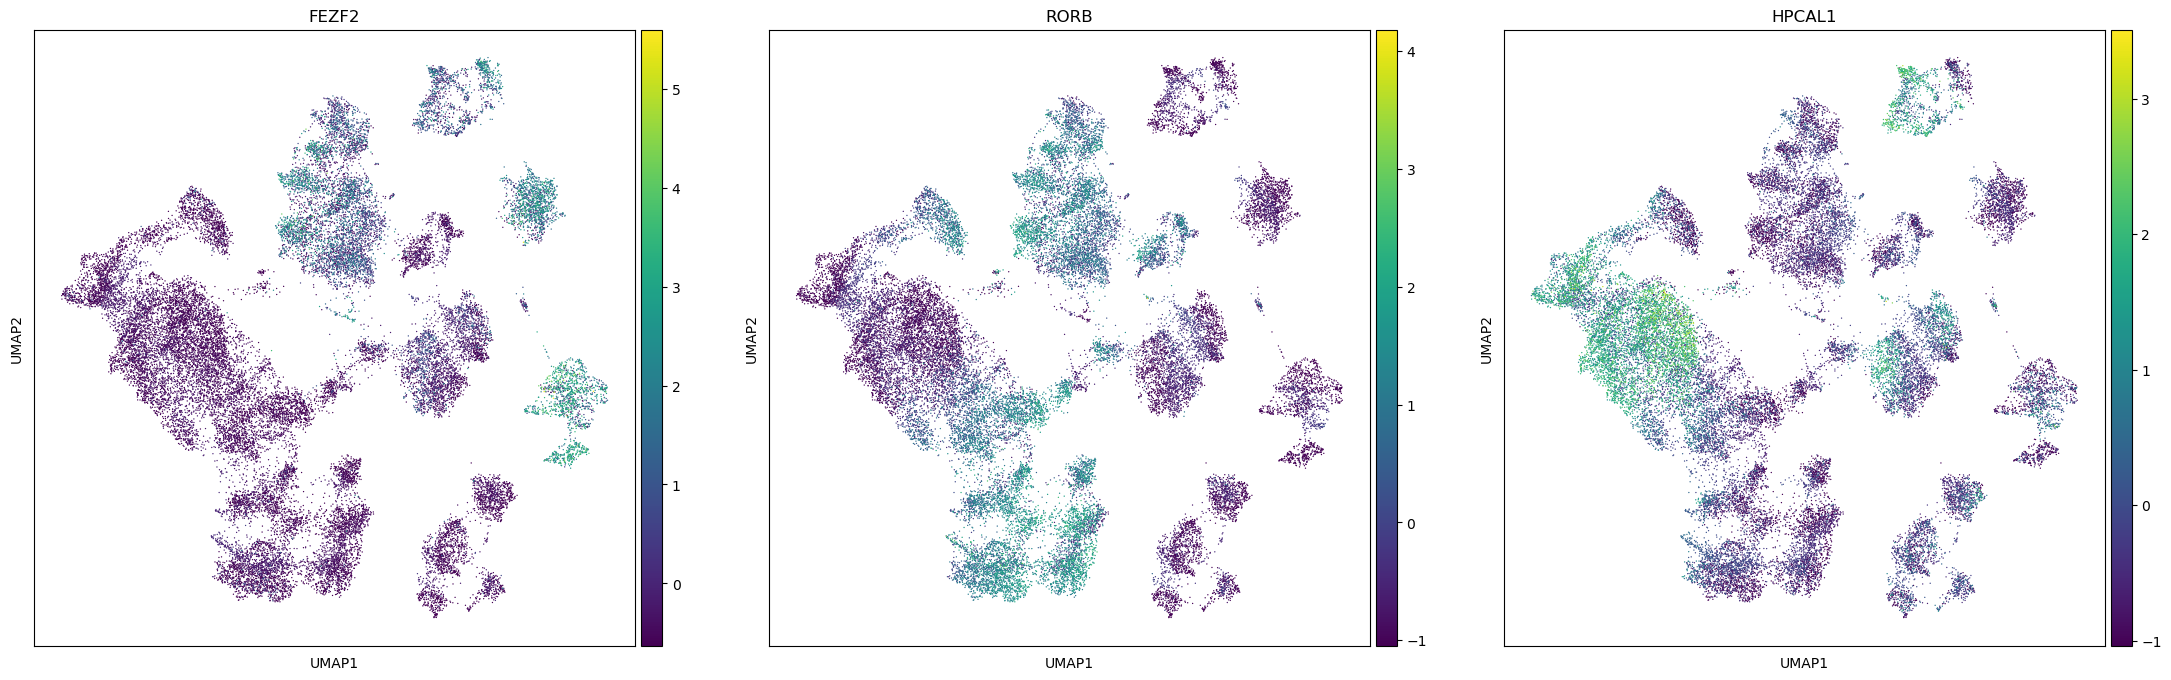

In [34]:
sc.pl.umap(adata, color = ['FEZF2','RORB','HPCAL1'], legend_loc = 'on data')

In [35]:
# set the first level markers groups...(used the louvain=1.8)
subclass_markers = adata.obs['species'].astype(str)
subclass_markers[adata.obs['louvain'].isin(['0','3','5','6','7','11','14','16','19','25','26','27','30'])] = 'HPCAL1'
subclass_markers[adata.obs['louvain'].isin(['1','9','10','13','20','21','23','28','31'])] = 'FEZF2'
subclass_markers[adata.obs['louvain'].isin(['2','4','8','12','15','17','18','22','24','30'])] = 'RORB'
adata.obs['subclass_markers'] = subclass_markers.astype('category')

# set the first level markers groups...
subclass_markers2 = subclass_markers
subclass_markers2[adata.obs['louvain'].isin(['16','27'])] = 'HPCAL1 1'
subclass_markers2[adata.obs['louvain'].isin(['11','19','29'])] = 'HPCAL1 2'
subclass_markers2[adata.obs['louvain'].isin(['0','3','6','7','25','26','30'])] = 'HPCAL1 3'
subclass_markers2[adata.obs['louvain'].isin(['5','14'])] = 'HPCAL1 4'

subclass_markers2[adata.obs['louvain'].isin(['13','28'])] = 'FEZF2 1'
subclass_markers2[adata.obs['louvain'].isin(['31'])] = 'FEZF2 2'
subclass_markers2[adata.obs['louvain'].isin(['1','9','20','21','23'])] = 'FEZF2 3'
subclass_markers2[adata.obs['louvain'].isin(['10'])] = 'FEZF2 4'


subclass_markers2[adata.obs['louvain'].isin(['4','24'])] = 'RORB 1'
subclass_markers2[adata.obs['louvain'].isin(['12'])] = 'RORB 2'
subclass_markers2[adata.obs['louvain'].isin(['18'])] = 'RORB 3'
subclass_markers2[adata.obs['louvain'].isin(['2','8','15','17','22',''])] = 'RORB 4'

adata.obs['subclass_markers2'] = subclass_markers2.astype('category')

adata.uns['subclass_markers2_colors'] = np.array([ '#98A14E', '#008000', '#2E8B57', '#96C390', '#6FBC1E', '#6D9269',
                                                  '#90EE90', '#224700', '#228B22', '#00FF7F', '#ADD8E6', '#4666A6',
                                                  '#1E90FF', '#B4BA77', '#1B655D', '#008B8B', '#00CED1', '#20B2AA',
                                                  '#66CDAA', '#00FF00',])

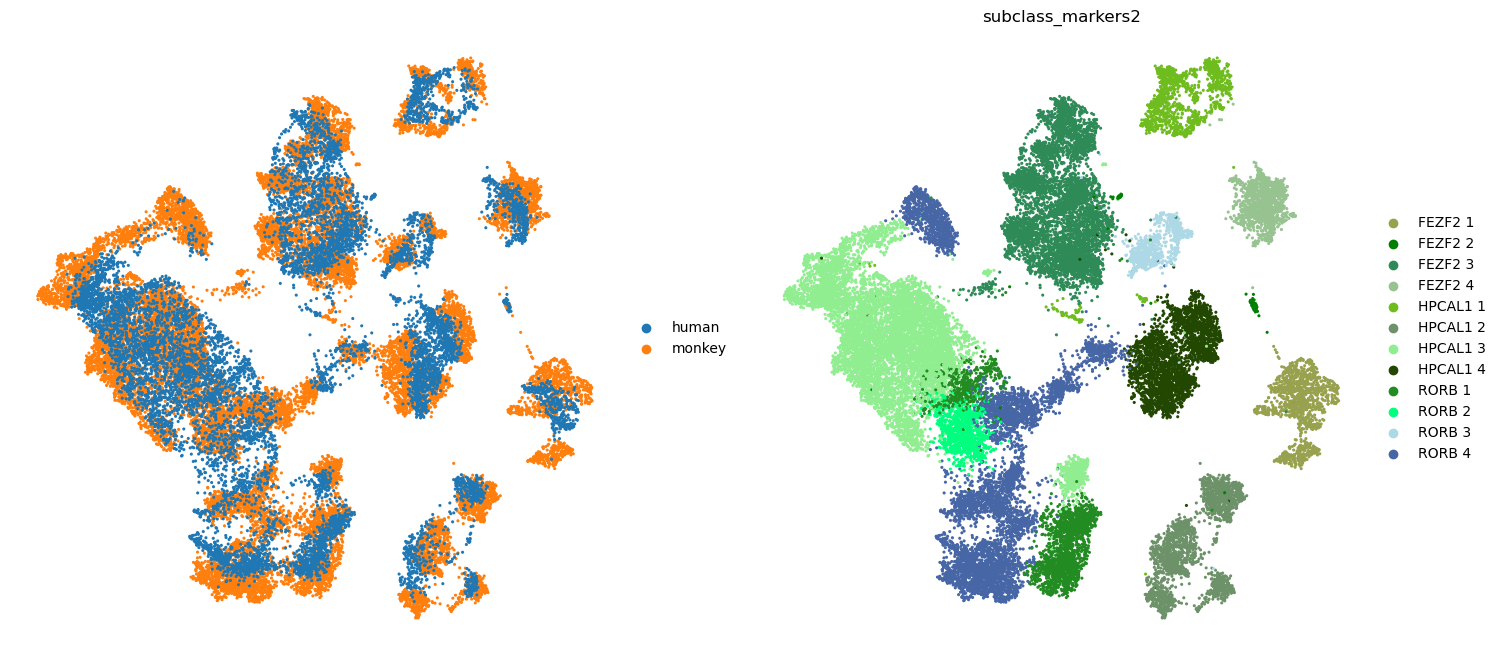

In [36]:
# plot the umaps
figsize(8,8)
sc.pl.umap(adata,color=['species','subclass_markers2'],legend_loc='right margin',size=20,frameon='',title='',save='umapClusterCmp_Exc_mkIns_vs_huMTG.pdf')

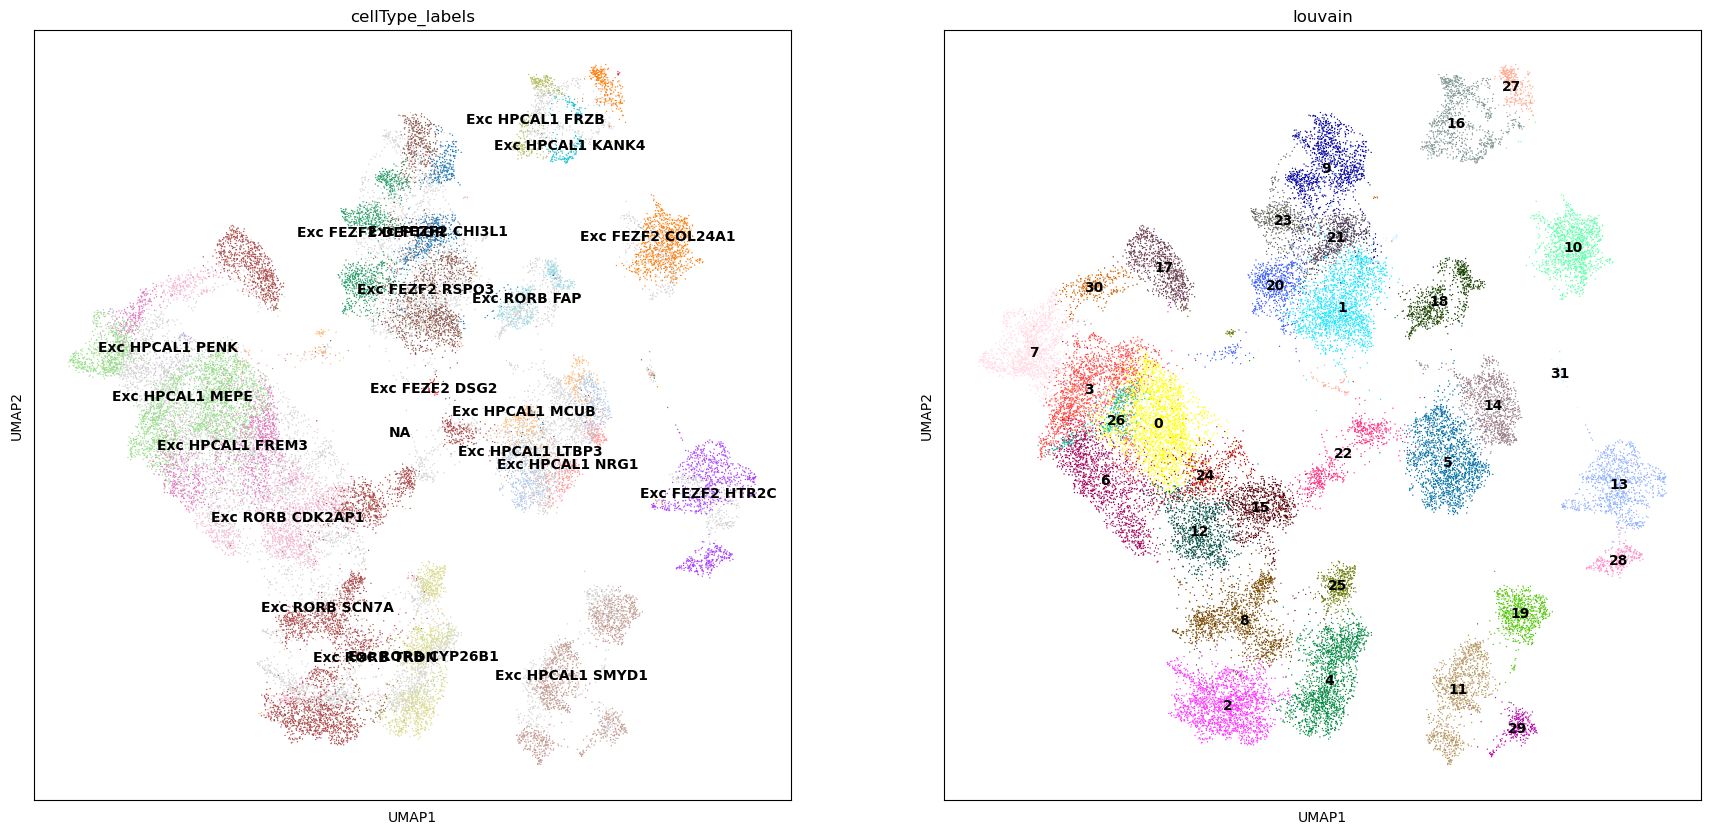

In [37]:
# ad_1 = adata[adata.obs['species'].isin(['monkey']),:]
figsize(10,10)
sc.pl.umap(adata, color = ['cellType_labels','louvain'], legend_loc = 'on data')

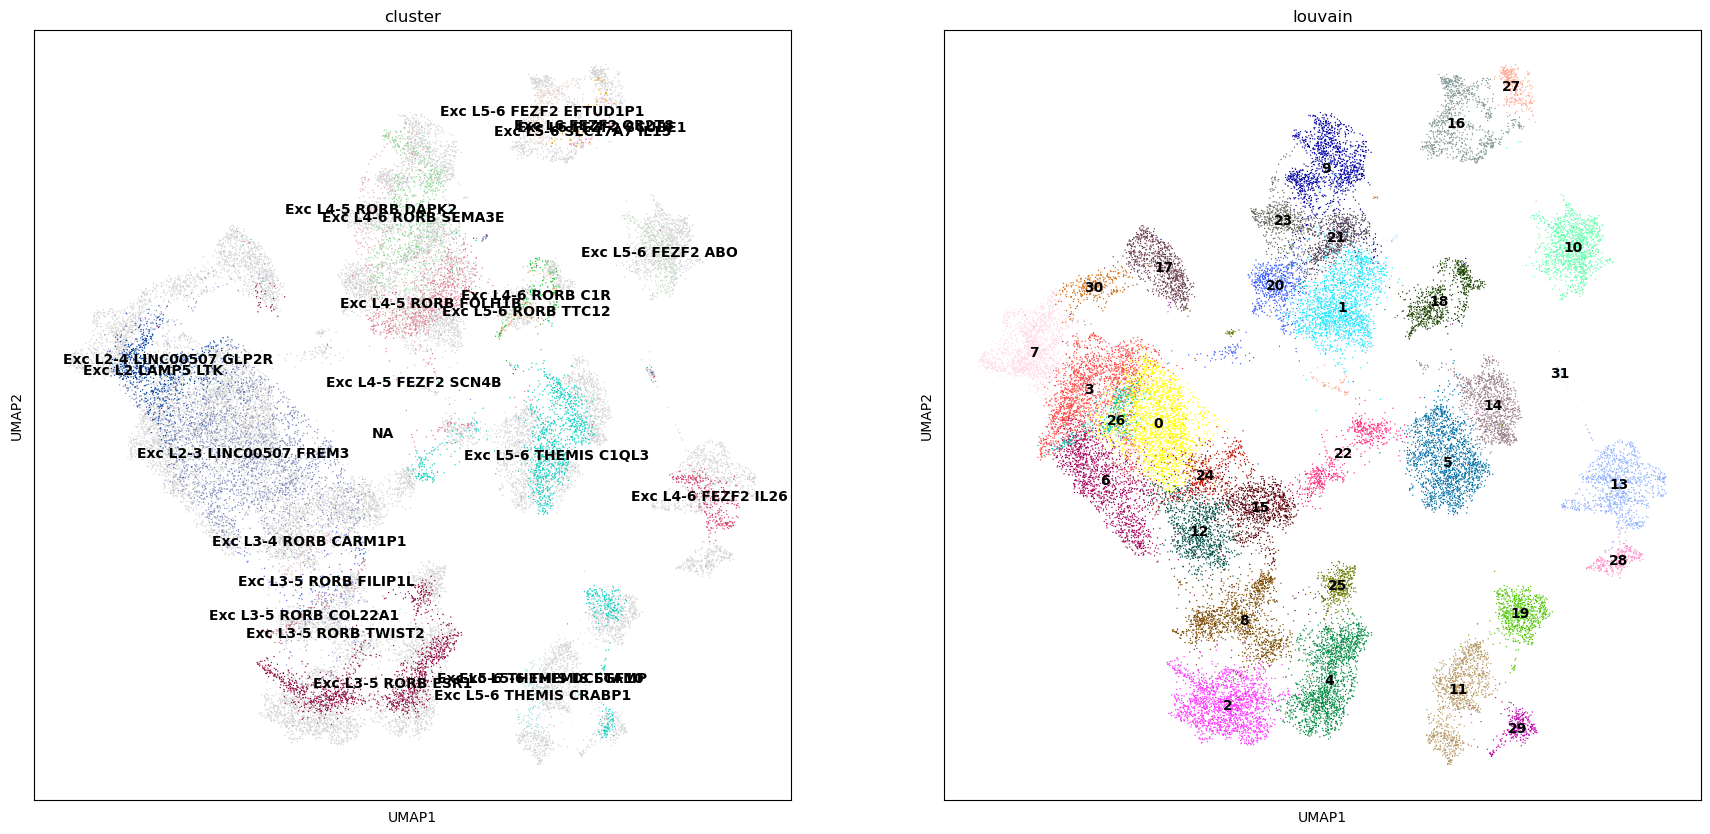

In [38]:
figsize(10,10)
sc.pl.umap(adata, color = ['cluster','louvain'], legend_loc = 'on data')